# 演習問題2 回帰 (Normal)

## 問題
以下の13個の変数からその地域の住宅価格の中央値(MEDV)を推測することができる回帰モデルを作成せよ.
1. CRIM	人口 1 人当たりの犯罪発生数
2. ZN	25,000 平方フィート以上の住居区画の占める割合
3. INDUS	小売業以外の商業が占める面積の割合
4. CHAS	チャールズ川によるダミー変数 (1: 川の周辺, 0: それ以外)
5. NOX	NOx の濃度
6. RM	住居の平均部屋数
7. AGE	1940 年より前に建てられた物件の割合
8. DIS	5 つのボストン市の雇用施設からの距離 (重み付け済)
9. RAD	環状高速道路へのアクセスしやすさ
10. TAX	10,000 ドルあたりの不動産税率の総計
11. PTRATIO	町毎の児童と教師の比率
12. B	町毎の黒人 (Bk) の比率を次の式で表したもの。 1000(Bk – 0.63)^2
13. LSTAT	給与の低い職業に従事する人口の割合 (%)

#### ヒント　
手順は以下の順番でおこなうとよい.

1. 欠損値があるかを確認する.
2. データを見て, どのアルゴリズムを使うかを決める.
3. ハイパーパラメータの最適化を行う.

(2と3は同時平行に行なってもよい.)

結局は、分類問題と回帰問題の違いはクラスを予測するか値を予測するかの違いのみである。

In [5]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import GridSearchCV

boston = datasets.load_boston()
#扱いづらいので, dataframe型のインターフェイスにする.
boston_df = pd.DataFrame(boston.data)
boston_df.columns = boston.feature_names
#今回の演習の目的変数に相当
boston_df["MEDV"] =  boston.target
#データの最初の5行を表示
boston_df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


欠損値があるかどうかを調べる.

In [3]:
boston_df.isnull().sum()#欠損値数の和を出力.

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
MEDV       0
dtype: int64

各変数の相関値を表示する. ここで, 目的変数との相関値が低い説明変数を選択しても意味はないどころか, 悪影響を及ぼす場合があるので注意する. しかし, 目視で変数選択をするの難しいため, Lasso回帰やAICを用いて変数選択するのがよい.

In [4]:
boston_df.corr() #各列の相関値を調べる.

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
CRIM,1.000000,-0.200469,0.406583,-0.055892,0.420972,-0.219247,0.352734,-0.379670,0.625505,0.582764,0.289946,-0.385064,0.455621,-0.388305
ZN,-0.200469,1.000000,-0.533828,-0.042697,-0.516604,0.311991,-0.569537,0.664408,-0.311948,-0.314563,-0.391679,0.175520,-0.412995,0.360445
INDUS,0.406583,-0.533828,1.000000,0.062938,0.763651,-0.391676,0.644779,-0.708027,0.595129,0.720760,0.383248,-0.356977,0.603800,-0.483725
CHAS,-0.055892,-0.042697,0.062938,1.000000,0.091203,0.091251,0.086518,-0.099176,-0.007368,-0.035587,-0.121515,0.048788,-0.053929,0.175260
NOX,0.420972,-0.516604,0.763651,0.091203,1.000000,-0.302188,0.731470,-0.769230,0.611441,0.668023,0.188933,-0.380051,0.590879,-0.427321
RM,-0.219247,0.311991,-0.391676,0.091251,-0.302188,1.000000,-0.240265,0.205246,-0.209847,-0.292048,-0.355501,0.128069,-0.613808,0.695360
AGE,0.352734,-0.569537,0.644779,0.086518,0.731470,-0.240265,1.000000,-0.747881,0.456022,0.506456,0.261515,-0.273534,0.602339,-0.376955
DIS,-0.379670,0.664408,-0.708027,-0.099176,-0.769230,0.205246,-0.747881,1.000000,-0.494588,-0.534432,-0.232471,0.291512,-0.496996,0.249929
RAD,0.625505,-0.311948,0.595129,-0.007368,0.611441,-0.209847,0.456022,-0.494588,1.000000,0.910228,0.464741,-0.444413,0.488676,-0.381626
TAX,0.582764,-0.314563,0.720760,-0.035587,0.668023,-0.292048,0.506456,-0.534432,0.910228,1.000000,0.460853,-0.441808,0.543993,-0.468536


### 線形回帰

まずは線形回帰(Lasso)を使ってみる.

In [6]:
from sklearn.linear_model import Lasso#lasso回帰を用いる.

rgs = Lasso(normalize=True)#ハイパーパラメータ設定

X_boston = boston_df.iloc[:,:13]#説明変数を格納
y_boston = boston_df.iloc[:,13]#目的変数を格納

params3 = {"alpha":[0, 0.001, 0.01,0.1, 1],"random_state":[0] }
cv_3 = GridSearchCV(rgs, params3, cv = 20 , n_jobs =-1,scoring= "neg_mean_squared_error")
cv_3.fit(X_boston, y_boston )
print("計算完了")

計算完了


 sklearnの場合, すべての評価指標はより高い値が低い値よりも優れている という規則に従うため、
MSE等の低い値が優れているとされている指標には-1をかけて負の数をして扱う.

In [7]:
cv_3.cv_results_["mean_test_score"] #Lasso回帰の結果

array([-31.6452746 , -31.48031827, -32.22701689, -41.6178923 ,
       -88.87120201])

In [ ]:
print("最適なハイパーパラメータは {}です".format(cv_3.best_params_))
print("回帰係数は{}です.".format(cv_3.best_estimator_.coef_))
print("切片は{}です.".format(cv_3.best_estimator_.intercept_))

### 非線形回帰分析

多項式回帰を用いて、非線形な回帰モデルを作成する.

In [8]:
from sklearn.preprocessing import PolynomialFeatures
# 2乗したデータまでを格納
quadratic  = PolynomialFeatures(degree = 2)
X_quadratic_boston = quadratic.fit_transform(X_boston)

In [9]:
params4 = {"alpha":[0, 0.001,0.01,0.1,1],"random_state":[0] }
cv_4 = GridSearchCV(rgs, params4, cv = 20 , n_jobs =-1,scoring= "neg_mean_squared_error")
cv_4.fit(X_quadratic_boston , y_boston )
cv_4.cv_results_

{'mean_fit_time': array([0.32928394, 0.29119203, 0.06566691, 0.00755914, 0.00653344]),
 'std_fit_time': array([0.11114003, 0.05162223, 0.05345507, 0.00596772, 0.00614428]),
 'mean_score_time': array([0.00115842, 0.00141896, 0.00088551, 0.00065498, 0.00065683]),
 'std_score_time': array([8.92943069e-04, 2.04544155e-03, 5.38400681e-04, 6.53199293e-05,
        7.77706814e-05]),
 'param_alpha': masked_array(data=[0, 0.001, 0.01, 0.1, 1],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_random_state': masked_array(data=[0, 0, 0, 0, 0],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'alpha': 0, 'random_state': 0},
  {'alpha': 0.001, 'random_state': 0},
  {'alpha': 0.01, 'random_state': 0},
  {'alpha': 0.1, 'random_state': 0},
  {'alpha': 1, 'random_state': 0}],
 'split0_test_score': array([-20.58283363, -10.49199615,  -9.85740024, -12.06776625,
        

In [10]:
cv_4.cv_results_["mean_test_score"]

array([-30.15794722, -23.76659106, -25.24424577, -37.370982  ,
       -88.87120201])

In [13]:
print("最適なハイパーパラメータは {}です".format(cv_4.best_params_))
print("回帰係数は{}です.".format(cv_4.best_estimator_.coef_))
print("切片は{}です.".format(cv_4.best_estimator_.intercept_))

最適なハイパーパラメータは {'alpha': 0.001, 'random_state': 0}です
回帰係数は[ 0.00000000e+00 -0.00000000e+00 -0.00000000e+00  7.31839578e-02
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -2.11061040e+00  2.45660023e-01  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  9.46243609e-04  5.48084095e-02
 -0.00000000e+00  2.85101471e+00 -1.61766629e-01 -0.00000000e+00
 -0.00000000e+00 -4.12514786e-02 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -1.08768224e-04 -0.00000000e+00  1.51649242e-04
 -4.46424927e-03 -1.48801020e-02  0.00000000e+00  9.83058842e-04
 -0.00000000e+00 -0.00000000e+00 -4.39169321e-04  7.17767288e-05
  0.00000000e+00  0.00000000e+00 -4.27806056e-03  5.10818473e-03
  0.00000000e+00  0.00000000e+00 -0.00000000e+00  2.82817337e-03
 -4.42153549e-02  0.00000000e+00  6.42265222e-05 -0.00000000e+00
  0.00000000e+00 -2.15267063e-02  0.00000000e+00 -1.22118952e+01
 -3.69097385e-01  0.00000000e+00  4.87840274e-01 -4.23339865e-01
 -0.00000000e+00  0.00000000e+00 

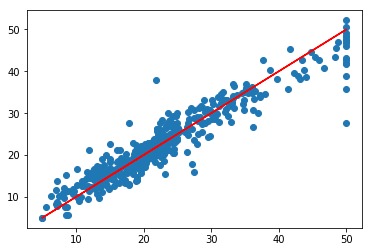

In [14]:
plt.scatter(y_boston, cv_4.predict(X_quadratic_boston))
plt.plot(y_boston, y_boston, color="r")
plt.show()

### まとめ
非線形回帰分析の方が表現力があがるため, 誤差の少ないモデルを構築することができた. 
今回は2次元までの多項式回帰を用いたが,　次元数を大きくし過ぎると過学習がおこり, 汎化性能はむしろ下がってしまうので注意.